## Task 2 – Russian Cities Housing Challenge 2025
ERP: 29005


## 1. Load Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)



c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\compat.py:105: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Train shape: (181507, 279)
Test shape: (77789, 278)


## 2. Column Types

In [21]:
X = train.drop(["price_doc", "id"], axis=1)
y = train["price_doc"]

num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

print(len(num_cols), "numeric columns")
print(len(cat_cols), "categorical columns")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=29005
)


262 numeric columns
15 categorical columns


## 3. Preprocessing Pipeline

In [3]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [4]:
def MSE(model, Xv, yv):
    pred = model.predict(Xv)
    return mean_squared_error(yv, pred)


## 4. Train All Models

## Regression Tree

In [5]:
tree_model = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(max_depth=16, random_state=29005))
])
tree_model.fit(X_train, y_train)

mse_tree = MSE(tree_model, X_val, y_val)
print("Regression Tree MSE:", mse_tree)


Regression Tree MSE: 205.59654496106685


## Linear Regression


In [6]:
lr_model = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])
lr_model.fit(X_train, y_train)

mse_lr = MSE(lr_model, X_val, y_val)
print("Linear Regression MSE:", mse_lr)


Linear Regression MSE: 171.64145124884038


## Gradient Boosting

In [ ]:
print("\nGradient Boosting")

gb_pipeline = Pipeline([
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=30,
        learning_rate=0.1,
        max_depth=4,
        random_state=29005
    ))
])

gb_pipeline.fit(X_train, y_train)

mse_gb = mean_squared_error(y_val, gb_pipeline.predict(X_val))
rmse_gb = np.sqrt(mse_gb)

print(f"  Validation MSE: {mse_gb:.4f}, RMSE: {rmse_gb:.4f}")



## Ridge Model


In [9]:
ridge_model = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0))
])
ridge_model.fit(X_train, y_train)

mse_ridge = MSE(ridge_model, X_val, y_val)
print("Ridge MSE:", mse_ridge)


Ridge MSE: 171.64605221416596


## LightGBM 

In [10]:
print("\n LightGBM (LGBMRegressor)")

lgbm_pipeline = Pipeline([
    ("prep", preprocess),   # ordinal encoding + imputation + scaling
    ("model", LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=8,
        random_state=29005
    ))
])

lgbm_pipeline.fit(X_train, y_train)

mse_lgbm = mean_squared_error(y_val, lgbm_pipeline.predict(X_val))
rmse_lgbm = np.sqrt(mse_lgbm)

print(f"  Validation MSE: {mse_lgbm:.4f}, RMSE: {rmse_lgbm:.4f}")





 LightGBM (LGBMRegressor)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66592
[LightGBM] [Info] Number of data points in the train set: 145205, number of used features: 277
[LightGBM] [Info] Start training from score 14.844082
  Validation MSE: 162.5836, RMSE: 12.7508


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## XGBOOST !!!

In [11]:
print("\nXGBoost")

xgb_pipeline = Pipeline([
    ("prep", preprocess),   
    ("model", XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=29005,
        tree_method="hist"  
    ))
])

xgb_pipeline.fit(X_train, y_train)

mse_xgb = mean_squared_error(y_val, xgb_pipeline.predict(X_val))
rmse_xgb = np.sqrt(mse_xgb)

print(f"  Validation MSE: {mse_xgb:.4f}, RMSE: {rmse_xgb:.4f}")




XGBoost
  Validation MSE: 162.1053, RMSE: 12.7321


## CATBOOST

In [12]:
try:
    from catboost import CatBoostRegressor

    print("\nCatBoost")

    # CatBoost wrapped inside preprocessing pipeline
    cat_pipeline = Pipeline([
        ("prep", preprocess),   # impute + ordinal encode all categories
        ("model", CatBoostRegressor(
            depth=8,
            iterations=100,
            learning_rate=0.05,
            verbose=0,
            random_seed=29005
        ))
    ])

    cat_pipeline.fit(X_train, y_train)

    mse_cat = mean_squared_error(y_val, cat_pipeline.predict(X_val))
    rmse_cat = np.sqrt(mse_cat)

    print(f"  Validation MSE: {mse_cat:.4f}, RMSE: {rmse_cat:.4f}")

except Exception as e:
    print("CatBoost failed — skipping.")
    print("Error:", e)
    mse_cat = None



CatBoost
  Validation MSE: 162.0640, RMSE: 12.7304


## Random Forest


In [ ]:
print("\nRandom Forest")

from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=150,
        max_depth=16,
        min_samples_split=20,
        min_samples_leaf=8,
        max_features='sqrt',
        random_state=29005,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

mse_rf = mean_squared_error(y_val, rf_pipeline.predict(X_val))
rmse_rf = np.sqrt(mse_rf)

print(f"  Validation MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}")



Random Forest
  Validation MSE: 159.0579, RMSE: 12.6118


## 5. MSE & RMSE Comparison Chart

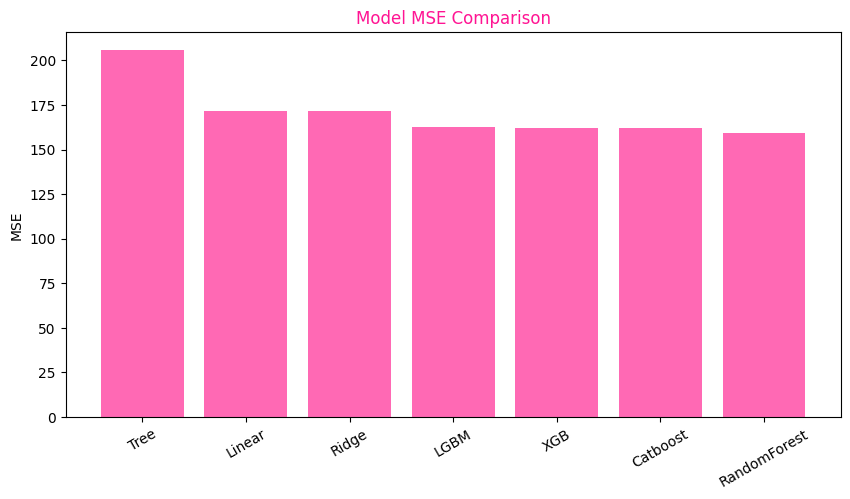

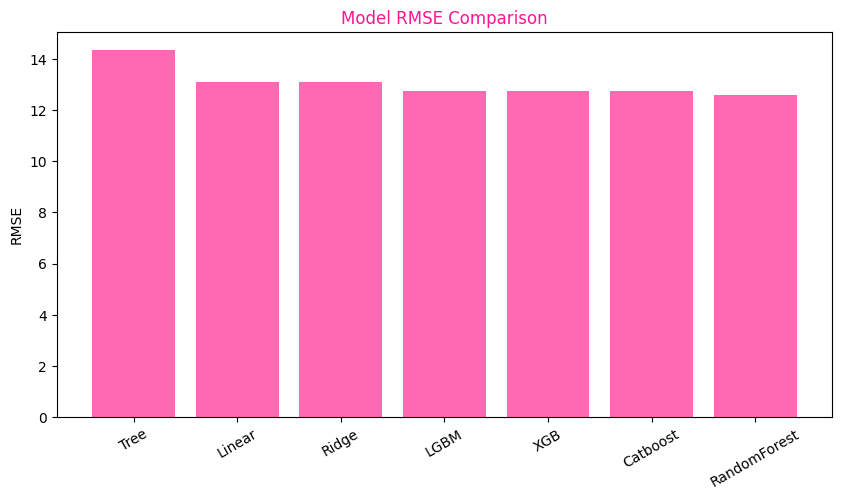

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

def MSE(model, X, y):
    preds = model.predict(X)
    return mean_squared_error(y, preds)

def RMSE(model, X, y):
    preds = model.predict(X)
    return np.sqrt(mean_squared_error(y, preds))

model_names = ["RandomForest"]

mse_values = [
    
    mse_rf
]

rmse_values = [
    np.sqrt(mse) if mse is not None else None
    for mse in mse_values
]

plt.figure(figsize=(10,5))
plt.bar(model_names, mse_values, color="#ff69b4")
plt.title("Model MSE Comparison", color="#ff1493")
plt.ylabel("MSE")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(10,5))
plt.bar(model_names, rmse_values, color="#ff69b4")
plt.title("Model RMSE Comparison", color="#ff1493")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.show()


In [17]:
best_mse = min(mse_values)
best_model_name = model_names[mse_values.index(best_mse)]

print("Best Model:", best_model_name)
print("Best MSE:", best_mse)
print("Best RMSE:", np.sqrt(best_mse))


Best Model: RandomForest
Best MSE: 159.05794471475377
Best RMSE: 12.611817661017534


## 6. Final Model (XGBoost)

In [ ]:

# FINAL MODEL SELECTION


print(f"\nBest model selected: {best_model_name}")

model_map = {
    "Tree": tree_model,
    "Linear": lr_model,
    "Ridge": ridge_model,
    "GB": gb_pipeline,
    "LGBM": lgbm_pipeline,
    "XGB": xgb_pipeline,
    "Catboost": cat_pipeline if mse_cat is not None else None,
    "RandomForest": rf_pipeline
}

final_model = model_map.get(best_model_name)

if final_model is None:
    print("Selected model not available. Using Tree.")
    final_model = tree_model

# TRAIN ON FULL TRAINING DATA

print("\nTraining final model on 100% data...")


from sklearn.pipeline import Pipeline

if isinstance(final_model, Pipeline):
    final_model.fit(X, y)   
else:
    
    cat_cols = X.select_dtypes(include=['object']).columns

    ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    ordinal_enc.fit(X[cat_cols])

    X_full_processed = X.copy()
    X_full_processed[cat_cols] = ordinal_enc.transform(X[cat_cols])

    final_model.fit(X_full_processed, y)

print("✔ Final model trained successfully!")



Best model selected: RandomForest

Training final model on 100% data...
✔ Final model trained successfully!


## 7. Kaggle Submission File

In [ ]:
print("\nProcessing test.csv with SAME preprocessing...")

test_processed = test.copy()


test_processed = test_processed.drop("id", axis=1)


test_processed[cat_cols] = ordinal_enc.transform(test_processed[cat_cols])

print("✓ Test encoding done")

print("\nPredicting on test.csv...")
preds = final_model.predict(test_processed)


submission = pd.DataFrame({
    "id": test["id"],
    "price_doc": preds
})

submission.to_csv("submission_task2.csv", index=False)
print("\n✓ submission_task2.csv created!")



Processing test.csv with SAME preprocessing...
✓ Test encoding done

Predicting on test.csv...

✓ submission_task2.csv created!
